In [1]:
import sys
sys.path.append('../src/')
import detector as de
import extractor as ex
import accumulator as ac
import utils
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from collections import defaultdict
import networkx as nx
import seaborn as sns
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random

# Define Parameters

In [2]:
folder_path = "D:/semantic-discovery/datasets/simpele bauornamentik afbeeldingen"
files = os.listdir(folder_path)
random_file = random.choice(files)
file_path = os.path.join(folder_path, random_file)
FILENAME = file_path


In [3]:
#folder_path = "D:/semantic-discovery/datasets/simpele bauornamentik afbeeldingen"
#files = os.listdir(folder_path)
#random_file = random.choice(files)
file_path = "D:/Thorsten M/Documenten/hoger onderwijs/4e jaar/masterproef/dataset/fc0f2513-4532-47a3-8e5a-a8d4d55551bb.jpeg"

#os.path.join(folder_path, random_file)
FILENAME = file_path
K = 7 # 7
RADIUS = 20 # 100
THRESHOLD = 1 # 1.5
N_SUPERPIXELS = 250 # 300
""" threshold value used for accumulator space thresholding. It determines the minimum value in the accumulator space for a point to be considered as a semantical hotspot.
""" 

N_KEYPOINTS = 10000 # 8000
SIGMA = 3 # 3
W = 11 # 11
ALPHA = 1 # 1


 # Image preprocessing

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
[

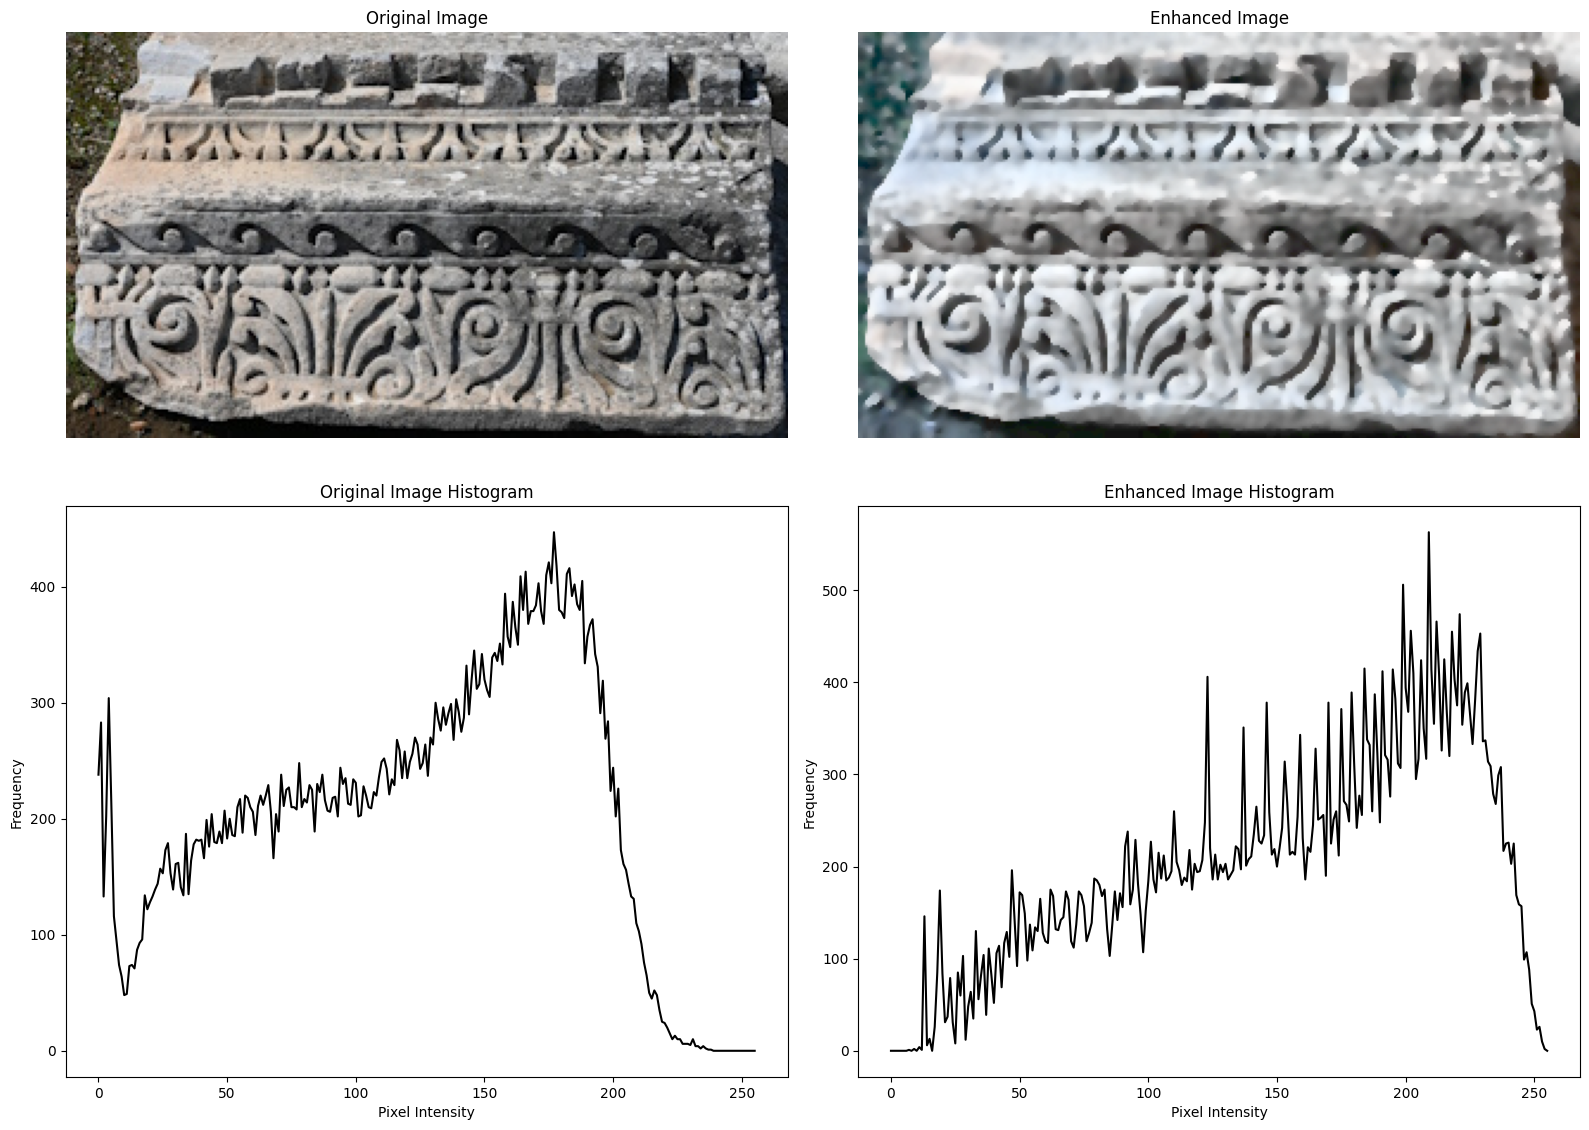

In [4]:
# Read the image and change encoding
original_img = cv2.imread(FILENAME, cv2.IMREAD_UNCHANGED)
plot_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)  # TO PLOT WITH MATPLOTLIB

# Apply Median Filtering
ksize = 3  # Adjust the kernel size as needed
median_img = cv2.medianBlur(original_img, ksize)

# Apply Bilateral Filtering
d = 5  # Diameter of each pixel neighborhood
sigma_color = 75  # Filter sigma in the color space
sigma_space = 75  # Filter sigma in the coordinate space
median_img_bgr = cv2.cvtColor(median_img, cv2.COLOR_RGB2BGR)
img_bilateral = cv2.bilateralFilter(median_img_bgr, d, sigma_color, sigma_space)


# Apply CLAHE to the L channel (lightness component)
lab_img = cv2.cvtColor(img_bilateral, cv2.COLOR_RGB2LAB)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])

# Convert the LAB image back to BGR color space
enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

# Apply gamma correction to further adjust contrast
enhanced_img = enhanced_img.astype(np.float32) / 255.0
gamma = 0.7  # Adjust the gamma value as needed
enhanced_img = cv2.pow(enhanced_img, gamma)
img = (enhanced_img * 255).astype(np.uint8)

# Calculate histograms
hist_original = cv2.calcHist([cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)], [0], None, [256], [0, 256])
hist_enhanced = cv2.calcHist([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256])

# Display the original and enhanced images inline
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.imshow(plot_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(enhanced_img)
plt.title('Enhanced Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(hist_original , color='black')
plt.title('Original Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.plot(hist_enhanced, color='black')
plt.title('Enhanced Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


 # A. Feature Localization and Extraction

 - Localization strategy: Canny
 - Descriptor: DAISY

In [5]:
# Detect interesting points
kpdetector = de.KeypointsDetector()
keypoints = kpdetector.canny(img, N_KEYPOINTS)

# Extract descriptors from detected points
extractor = ex.DescriptorExtractor()
descriptors = extractor.daisy(keypoints, img)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


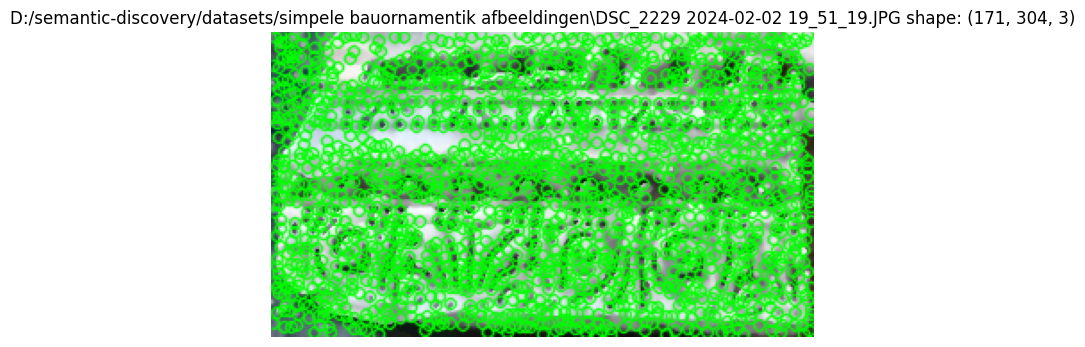

In [6]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.imshow(img)
ax.axis('off')
ax.set_title(f"{FILENAME} shape: {img.shape}")
ax.imshow(cv2.drawKeypoints(img, keypoints, img.copy(), (0, 255, 0)))
plt.show()


 # B. Semantical Hot Spots Detection

 - For each source descriptor, compute top `K` approximate destination neighbors
 - Add splash ends in the Accumulator
     - Gaussian voting scheme with ksize=11. Kernel sums to 1.
     - Exponential decreasing weight of the Gaussian. `kernel * 1/rank`
     - Do NOT include splash ends within `RADIUS`

In [7]:
# Accumulator Declaration
accumulator = ac.Accumulator(img)

# Implementation uses FLANN matcher instead of descriptor matrix
FLANN_INDEX_KDTREE = 0
flann = cv2.FlannBasedMatcher(dict(algorithm=FLANN_INDEX_KDTREE, trees=5), dict(checks=50))
matches = flann.knnMatch(descriptors, descriptors, k=K)

for i, m_list in enumerate(matches):
    o = (int(keypoints[i].pt[1]), int(keypoints[i].pt[0]))
    points = []
    rank = 1
    for m in m_list:
        d = (int(keypoints[m.trainIdx].pt[1]), int(keypoints[m.trainIdx].pt[0]))
        # Remove points near the source
        if utils.eu_dist(o, d) > RADIUS:
            points.append(d)
            accumulator.add_vote(o, d, rank**2, ksize=W)
            rank += 1
    accumulator.add_splash(o, points)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
[

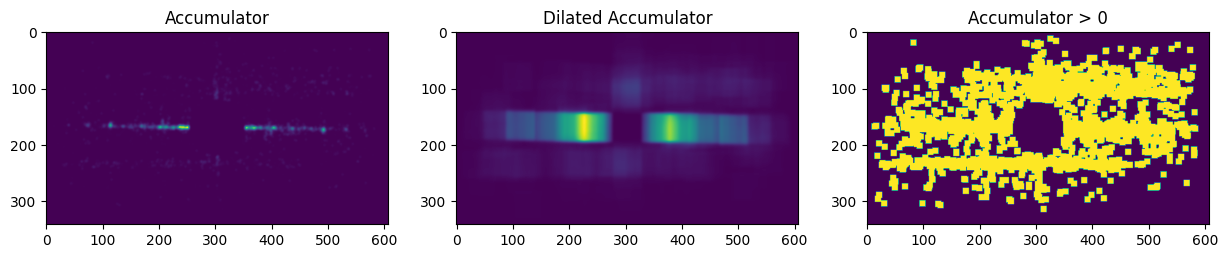

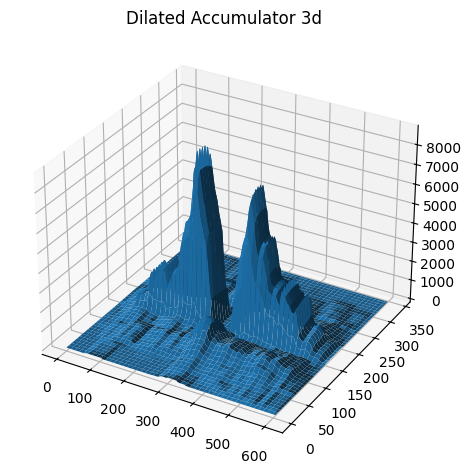

In [8]:
# Accumulator visualization
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

axs[0].set_title("Accumulator")
axs[0].imshow(accumulator.accumulator)

axs[1].set_title("Dilated Accumulator")
axs[1].imshow(cv2.filter2D(accumulator.accumulator,-1, np.ones((51,51),np.uint8)))

axs[2].set_title("Accumulator > 0")
axs[2].imshow(accumulator.accumulator>0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y = np.arange(0, accumulator.accumulator.shape[0])
x = np.arange(0, accumulator.accumulator.shape[1])
x, y = np.meshgrid(x, y)
ax.set_title("Dilated Accumulator 3d")
ax.plot_surface(x,y, cv2.filter2D(accumulator.accumulator,-1, np.ones((51,51),np.uint8)))
plt.tight_layout()
plt.show()

 ## Accumulator Space Thresholding

In [9]:
# Threshold above 5% max or less
x, y = np.where(accumulator.accumulator > THRESHOLD)

# Vote list is V in the paper
vote_list = accumulator.votes.copy()
idx1 = np.nonzero(np.isin(vote_list[:, 0], x))[0]
idx2 = np.nonzero(np.isin(vote_list[idx1, 1], y))[0]
idx3 = idx1[idx2]
mask = np.zeros(vote_list.shape[0])

coords = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)

for coord in coords:
    idx4 = np.where(np.all(vote_list[idx3, 0:2] == coord, axis=1))[0]
    mask[idx3[idx4]] = 1

vote_list = vote_list[np.nonzero(mask)[0]]


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
[

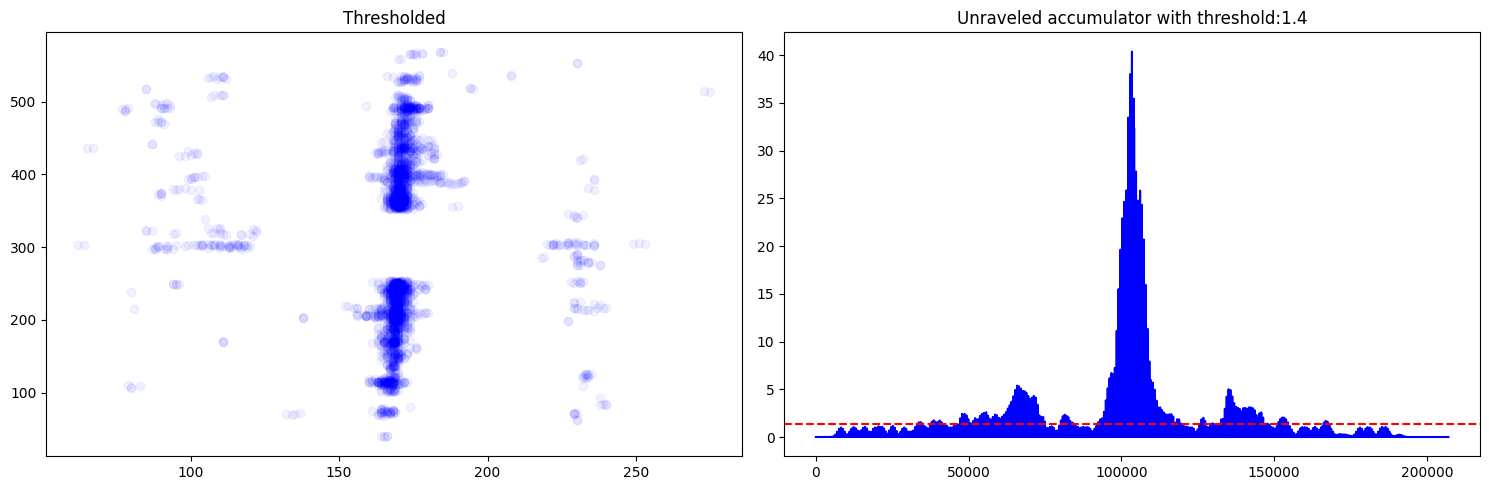

In [10]:
# Debug plot
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title(f"Thresholded")
plt.scatter(vote_list[:,0], vote_list[:,1], c='b', alpha=0.05)

plt.subplot(1,2,2)
plt.title(f"Unraveled accumulator with threshold:{THRESHOLD}")
plt.plot(accumulator.accumulator.flatten(), c='b')
plt.axhline(y=THRESHOLD, color='r', linestyle='dashed')
plt.tight_layout()

 ## Backprojection

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


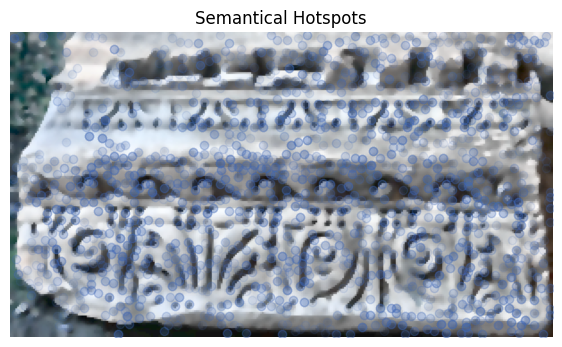

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
plt.axis('off')
ax.imshow(img)
ax.set_title("Semantical Hotspots")
ax.scatter(vote_list[:, 3], vote_list[:, 2], c='#426ab9ff', alpha=0.1)
plt.show()


 # C. Semantical Categories Definition and Extraction


In [12]:
# Run from here with different N_SUPERPIXELS values to reach other semantical levels
segments = slic(img, n_segments=N_SUPERPIXELS, compactness=20, sigma=SIGMA)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


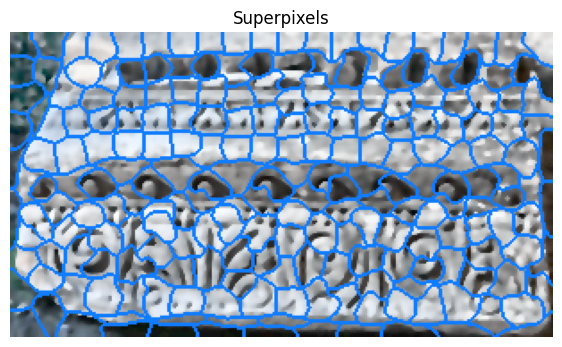

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.imshow(mark_boundaries(img, segments, color=(16/255, 124/255, 255/255), mode="thick"))
ax.set_title("Superpixels")
ax.axis("off")
plt.show()


 ## Graph creation

 - $G=(V,E)$
     - $|V|=$ number of clusters found
     - $E =$ Put 1 vote between $v_{1}$ and $v_{2}$ if there is an agreement between two superpixels


In [14]:
connections = []
for vote in vote_list:
    pi1 = vote[2:4]
    pi2 = vote[4:6]
    connections.append((segments[pi1[0], pi1[1]], segments[pi2[0], pi2[1]]))


In [15]:
n_clusters = segments.max() + 1


In [16]:
adj_mat = np.zeros((n_clusters, n_clusters))
for c in connections:
    adj_mat[c[0], c[1]] += 1
    adj_mat[c[1], c[0]] += 1

np.fill_diagonal(adj_mat, 0)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
[

C:\Users\thors\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


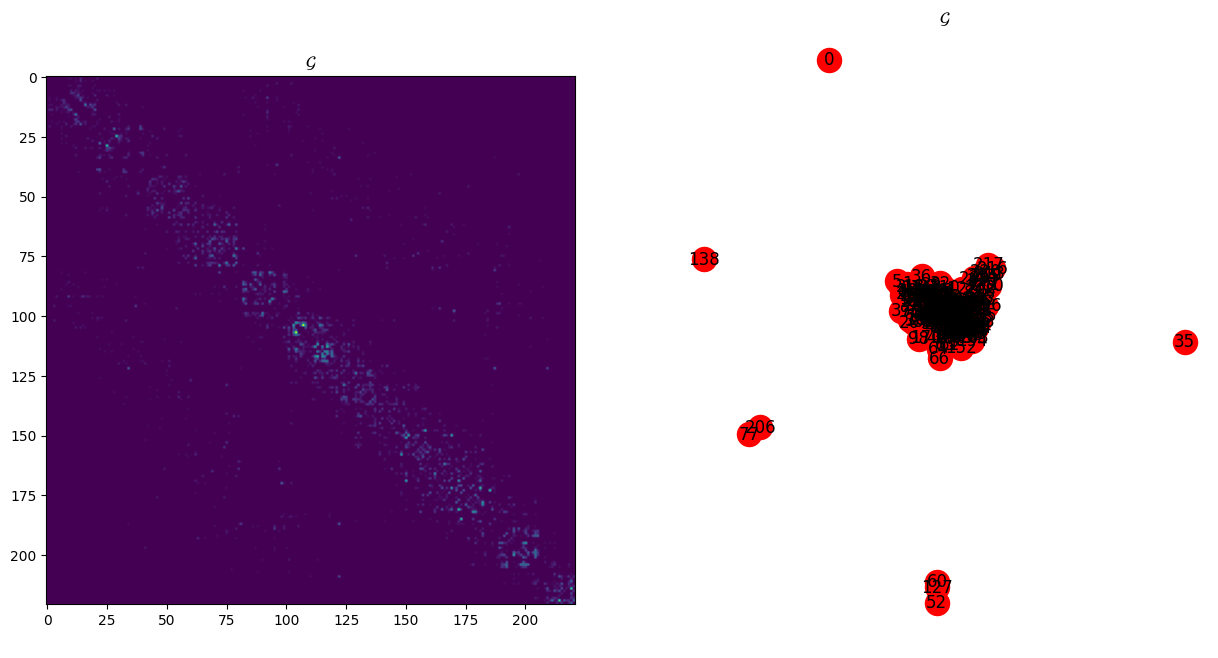

In [17]:
# Visualization
fig = plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("$\mathcal{G}$")
plt.imshow(adj_mat)

# Draw graph
G = nx.from_numpy_array(adj_mat)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
weights = np.array(weights)
weights /= weights.max()
maxw = weights.max()
weights *= 10
plt.subplot(1, 2, 2)
plt.title("$\mathcal{G}$")
nx.draw(G, node_color='r', with_labels=True, edge_color=weights, width=weights, cmap=plt.cm.jet)#,  pos = pos)
plt.show()


 ## Discover Categories

 - Find densely connected components by iterative process: graph corrosion
 - At each iteration corrode the graph $G-min(E)$ and compute a score as follows:

 $s(G, K)=\sum_{k \in K} \mu(k)-\alpha|K|$

 Maximize the score to find the optimum partition

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


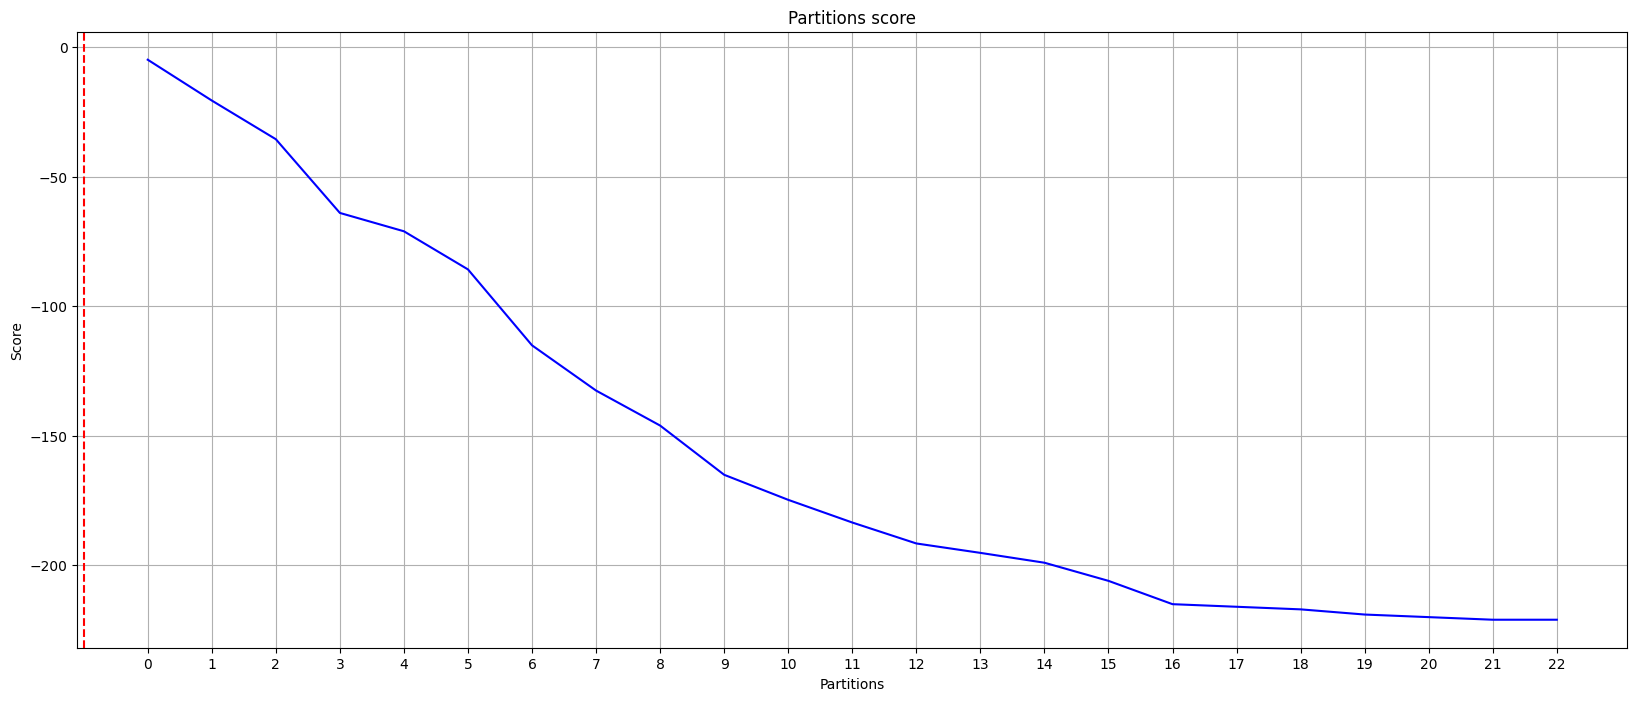

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[]


In [18]:
best_partition_nodes, best_partition = utils.findBestPartition_alt(adj_mat, alpha=ALPHA, viz=True)
print(best_partition)
print(best_partition_nodes)

 ## Plot of categories and subgraphs extracted

In [19]:
pred, rmask = utils.plot_spixel_segmentation(plot_img, best_partition_nodes, segments)
utils.draw_subgraphs(adj_mat, best_partition_nodes, maxw)
print(pred)
print(rmask)

[]


ZeroDivisionError: integer division or modulo by zero

<Figure size 3000x3000 with 0 Axes>

 # Final result

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Final result")
plt.imshow(rmask, alpha=0.5)
plt.axis('off')
plt.show()
